# Quantized Low-Rank Adapters (QLoRA)

Paper: https://arxiv.org/pdf/2305.14314

PEFT library guide: https://huggingface.co/docs/peft/en/developer_guides/lora#lora

Let's start with a review of quantization. A naive quantization scheme from `fp32` to `int8` would simply rescale the inputs before rounding, and would look like this:

$$
\mathbf{X}^{\mathrm{Int8}}=\operatorname{round}\left(\frac{127}{\operatorname{absmax}\left(\mathbf{X}^{\mathrm{FP} 32}\right)} \mathbf{X}^{\mathrm{FP} 32}\right)=\operatorname{round}\left(c^{\mathrm{FP} 32} \cdot \mathbf{X}^{\mathrm{FP} 32}\right)
$$

where
- $\mathbf{X}^{\mathrm{FP} 32}$ is an input tensor (in precision `fp32`),
- 127 is the maximum value of an `int8` signed integer using 8 bits (replace by $2^{n_{\text{bits}}-1}-1$ if $n_{\text{bits}}\neq 8$), and
- $\operatorname{absmax}\left(\mathbf{X}^{\mathrm{FP} 32}\right)$ is the maximum (absolute) value of the input tensor,
- $c^{\mathrm{FP} 32}$ is called the "rescaling factor".

Let's see the kind of approximations that are made with this quantization scheme.

In [1]:
%pip install -q accelerate bitsandbytes trl peft transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
class Quantization:
    """Implements "naive" integer quantization with rescaling."""
    def __init__(self, bits=4):
        self.bits = bits
        self.quantization_scale = None

    def quantize(self, X):
        """The quantization scale is computed during quantization, and is needed for
        dequantization (notably, computes the absmax of the input tensor.)"""
        self.quantization_scale = (2**(self.bits - 1) - 1)/np.abs(X).max()
        return np.round(self.quantization_scale * X)

    def dequantize(self, quantized_value):
        """Restore initial values"""
        return quantized_value / self.quantization_scale

quant = Quantization(bits=4)
X = np.random.uniform(-1, 1, 10)
print(f"Input tensor: {X}")
X_quant = quant.quantize(X)
print(f"Quantized: {X_quant}")
print(f"Dequantized: {quant.dequantize(X_quant)}")

Input tensor: [ 0.31280914  0.55544498  0.61973782 -0.31506674  0.11967455 -0.68322584
  0.38825619  0.17450365 -0.49177243 -0.78269681]
Quantized: [ 3.  5.  6. -3.  1. -6.  3.  2. -4. -7.]
Dequantized: [ 0.33544149  0.55906915  0.67088298 -0.33544149  0.11181383 -0.67088298
  0.33544149  0.22362766 -0.44725532 -0.78269681]


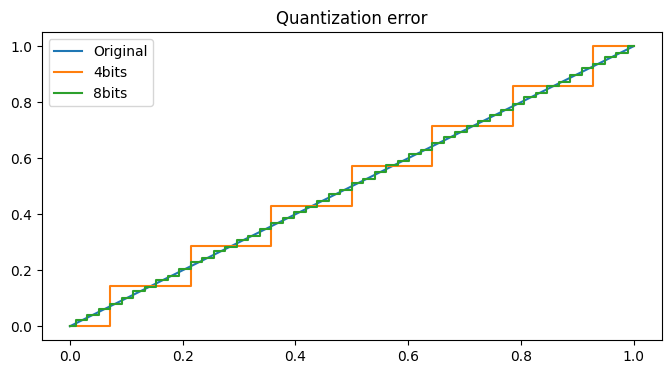

In [4]:
x = np.linspace(0, 1., 50)

quant4 = Quantization(bits=4)
quant8 = Quantization(bits=8)

y_4bits = quant4.dequantize(quant4.quantize(x))
y_8bits = quant8.dequantize(quant8.quantize(x))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, x, label="Original")
ax.step(x, y_4bits, label="4bits", where="mid")
ax.step(x, y_8bits, label="8bits", where="mid")
ax.set_title("Quantization error")
plt.legend()

Note that this quantization scheme is very sensitive to outliers, i.e. if the  maximum (absolute) value of the input tensor ($\operatorname{absmax}\left(\mathbf{X}^{\mathrm{FP} 32}\right)$) is much larger than other values, then most values are quantized to the same bucket. 

### Dealing with the outlier problem: 4-bit NormalFloat Quantization 
From the paper: 
> QLORA has one low-precision storage data type, in our case usually 4-bit, and one computation data
type that is usually BFloat16. In practice, this means whenever a QLORA weight tensor is used, we
dequantize the tensor to BFloat16, and then perform a matrix multiplication in 16-bit.

To mitigate the outlier issue mentioned above, QLoRA introduces the 4-bit NormalFloat format (`nf4`). The latter consists in rescaling the standard deviation of the weight tensor to match the standard deviation of the 4-bits data type. The $2^4=16$ values of the target data type then map to the following quantiles of the normal distribution:

$$
q_i=\frac{1}{2}\left(Q_X\left(\frac{i}{2^k+1}\right)+Q_X\left(\frac{i+1}{2^k+1}\right)\right)
$$

where $Q_X(\cdot)$ is the quantile function of the standard normal distribution $\mathcal{N}(0,1)$.

QLoRA also adds two optimizations on top of the above quantization mechanism: 
- double quantization, in which the quantization scales are in turn quantized
- paged optimizers: offload some gradients to the CPU to avoid memory spikes



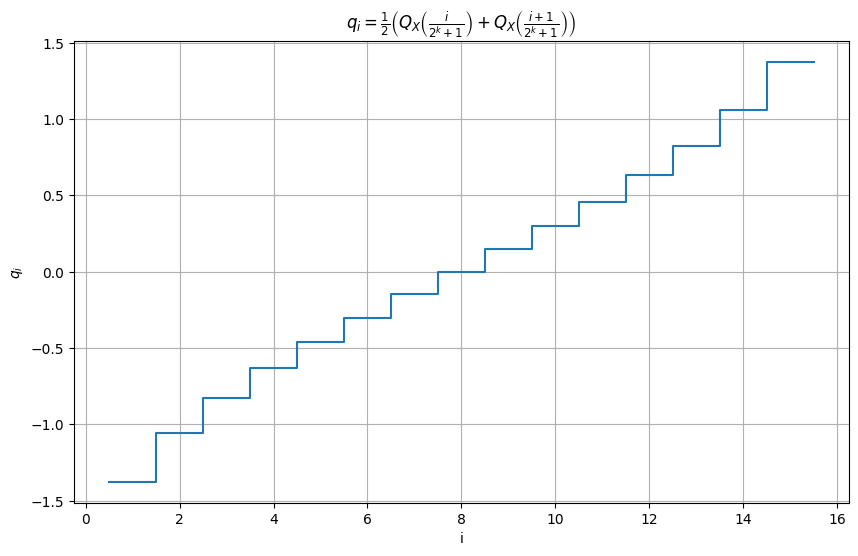

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Q_X = norm.ppf # Quantile function for the standard normal distribution

def q_i(i, k):
    return 0.5 * (Q_X(i / (2**k + 1)) + Q_X((i + 1) / (2**k + 1)))

n_bits = 4  # Example value for k
i_values = np.arange(0, 2**(n_bits+1) + 1)
q_i_values = [q_i(i, n_bits) for i in i_values]

plt.figure(figsize=(10, 6))
plt.step(i_values, q_i_values, marker='', where="mid")
plt.title(r'$q_i = \frac{1}{2}\left(Q_X\left(\frac{i}{2^k+1}\right)+Q_X\left(\frac{i+1}{2^k+1}\right)\right)$')
plt.xlabel('i')
plt.ylabel(r'$q_i$')
plt.grid(True)
plt.show()

## QLoRA fine-tuning

In [6]:
from huggingface_hub import login
login()

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# https://huggingface.co/docs/transformers/en/peft#train-a-peft-adapter
# model_name = "bigscience/bloomz-560m"
# target_modules = ["query_key_value"]

# model_name = "meta-llama/Meta-Llama-3-8B"
model_name = "google/gemma-2b"
target_modules = ["q_proj", "v_proj"]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)


model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    # torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Dataset
We'll fine-tune Llama3 on the following math problem dataset:
https://huggingface.co/datasets/microsoft/orca-math-word-problems-200k

In [9]:
from datasets import load_dataset

dataset = load_dataset("microsoft/orca-math-word-problems-200k")
dataset["train"][0]

{'question': 'Jungkook is the 5th place. Find the number of people who crossed the finish line faster than Jungkook.',
 'answer': 'If Jungkook is in 5th place, then 4 people crossed the finish line faster than him.'}

In [10]:
dataset["train"][10]

{'question': 'This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.',
 'answer': "Let's denote Minsu's current age as M and his mother's current age as M_m.\n\nAccording to the information given, we have two equations:\n\n1) M_m - M = 28 (The age difference between Minsu and his mother is 28 years)\n\n2) M_m + 13 = 2(M + 13) (After 13 years, the mother's age will be twice Minsu's age)\n\nNow, let's solve these equations step by step.\n\nFrom equation 1, we can express M_m in terms of M:\n\nM_m = M + 28\n\nNow, let's substitute M_m in equation 2 with the expression we found from equation 1:\n\n(M + 28) + 13 = 2(M + 13)\n\nSimplify the equation:\n\nM + 41 = 2M + 26\n\nNow, let's solve for M:\n\n2M - M = 41 - 26\nM = 15\n\nSo, Minsu is currently 15 years old."}

In [11]:
# From: https://huggingface.co/docs/trl/en/sft_trainer#add-special-tokens-for-chat-format
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['question'])):
        text = f"### Question: {example['question'][i]}\n ### Answer: {example['answer'][i]}"
        output_texts.append(text)
    return output_texts

def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,
        early_stopping=False,
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

question = dataset["train"][10]["question"]
print(f"Question: {question}")
question = formatting_prompts_func({
    "question": [question],
    "answer": [""],
})
input_sentences = tokenizer(question, return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)[0])

Question: This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.
### Question: This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.
 ### Answer: 15

import math
def main():
    age_m = int(input("Enter your current age: "))
    print("Your mom's age in next 40 years:", (math.ceil((60-age


## Fine-Tuning.

Let's first try to fine-tune the entire model.

In [26]:
dataset["train"].select(range(100))

Dataset({
    features: ['question', 'answer'],
    num_rows: 100
})

In [27]:
from transformers import (
    DataCollatorForLanguageModeling, TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir=".",
    per_device_train_batch_size=2,
    # auto_find_batch_size=True,
    learning_rate=2e-4,
    num_train_epochs=1
)



lora_config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model.add_adapter(lora_config)

tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset["train"].select(range(100)),
    formatting_func=formatting_prompts_func,
    tokenizer=tokenizer,
    data_collator=data_collator,
    peft_config=lora_config,
)

# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=50, training_loss=1.0903746032714843, metrics={'train_runtime': 17.3996, 'train_samples_per_second': 5.747, 'train_steps_per_second': 2.874, 'total_flos': 336515525001216.0, 'train_loss': 1.0903746032714843, 'epoch': 1.0})

In [28]:
question = dataset["train"][10]["question"]
print(f"Question: {question}")
question = formatting_prompts_func({
    "question": [question],
    "answer": [""],
})
input_sentences = tokenizer(question, return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)[0])

Question: This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.
### Question: This year, the age difference between Minsu and his mother is 28 years old, and after 13 years, the age of his mother will be twice that of Minsu. Find the age of Minsu this year.
 ### Answer: 

Let's start by finding out how many years have passed since Minsu was born until now. Since he has been living with his mother for 13 years (since birth), we can subtract 5 from it to find out how many
